# Preparation

This Colab is for demonstration only to help you learn course concepts—you’re not required to write code on your own.

**Notice: all the code you could modify with surrounded by a comment like following:**

```
# edit area: define the sentences you want to analyze---------------
sentences_to_analyze = [
    "What starts here",
    "The Texas Longhorns"
]
# -----------edit area end------------------------------------------
```

**do not modify the code out of edit area**


In [1]:
# the following code will ask you to restart the kernel
!pip install gensim
!wget https://raw.githubusercontent.com/sangyx/MIS372T/refs/heads/main/lecture2_utils.py
from lecture2_utils import *

--2025-08-28 19:04:36--  https://raw.githubusercontent.com/sangyx/MIS372T/refs/heads/main/lecture2_utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12330 (12K) [text/plain]
Saving to: ‘lecture2_utils.py.1’

lecture2_utils.py.1 100%[===================>]  12.04K  --.-KB/s    in 0.001s  

2025-08-28 19:04:36 (18.4 MB/s) - ‘lecture2_utils.py.1’ saved [12330/12330]



#Probabilistic distribution ​

Large Language Models (LLMs) generate text by predicting the next token in a sequence. The model does not give a single answer; instead, it outputs a set of raw scores, called logits, for every possible token. The softmax function then converts these logits into a probability distribution, where each possible next token has a probability between 0 and 1, and the sum of all probabilities is 1. The model can then select the next word based on this distribution.

---

The code in this section uses the gpt2 model to demonstrate this process. You will provide sentences in the sentences_to_analyze list to see the top five most probable next tokens and their corresponding probabilities. The purpose of this exercise is to show how LLMs predict the next word by assigning probabilities to a large set of potential words.



In [2]:
# Import PyTorch (the compute backend) and Hugging Face Transformers
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

# Pick a pretrained checkpoint by name ("gpt2" is a small, open model)
checkpoint = "gpt2"

# Load the tokenizer: turns text into tokens the model understands
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

# Load the model weights for a causal language model (next-token predictor)
model = AutoModelForCausalLM.from_pretrained(checkpoint)

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [18]:
# edit area: define the sentences you want to analyze---------------
sentences_to_analyze = [
    "What starts here",
    "The Texas Longhorns",
    "I am a dude",
    "I am gay",
    "I am not gay"
]
# -----------edit area end------------------------------------------

In [19]:
# Get the probability distribution for each sentence

# top tokens to display
num_results = 10

for sentence in sentences_to_analyze:
    # Tokenize the input text. Add `return_tensors='pt'` to get PyTorch tensors.
    input_ids = tokenizer.encode(sentence, return_tensors='pt')

    # Get the model's raw output (logits) without generating a full response.
    # The `outputs` object contains the `logits` for each token in the sequence.
    with torch.no_grad():
        outputs = model(input_ids)

    # The logits for the next token are the logits of the last token in the sequence.
    # We select the last token's logits (outputs.logits[0, -1, :])
    last_token_logits = outputs.logits[0, -1, :]

    # Apply the softmax function to convert logits into probabilities.
    # This gives us the probability distribution over the entire vocabulary.
    probabilities = torch.softmax(last_token_logits, dim=-1)

    # Get the top N most probable tokens and their corresponding probabilities.
    # `topk` returns both the values (probabilities) and their indices (token IDs).
    top_probabilities, top_indices = torch.topk(probabilities, num_results)

    # output results
    print("\n" + "="*50)
    print(f"Probability Distribution for: '{sentence}'")
    print("="*50)
    for i in range(num_results):
        token_id = top_indices[i].item()
        token_text = tokenizer.decode([token_id]).strip()
        probability = top_probabilities[i].item()
        print(f"  Token: '{token_text}' -> Probability: {probability:.4f}")


Probability Distribution for: 'What starts here'
  Token: 'is' -> Probability: 0.4353
  Token: ',' -> Probability: 0.1789
  Token: ':' -> Probability: 0.0916
  Token: '?' -> Probability: 0.0252
  Token: 'in' -> Probability: 0.0235
  Token: 'will' -> Probability: 0.0191
  Token: 'are' -> Probability: 0.0187
  Token: '.' -> Probability: 0.0119
  Token: 'with' -> Probability: 0.0103
  Token: 'can' -> Probability: 0.0101

Probability Distribution for: 'The Texas Longhorns'
  Token: 'are' -> Probability: 0.0954
  Token: 'have' -> Probability: 0.0793
  Token: 'will' -> Probability: 0.0715
  Token: ',' -> Probability: 0.0655
  Token: '(' -> Probability: 0.0298
  Token: 'and' -> Probability: 0.0296
  Token: 'were' -> Probability: 0.0288
  Token: ''' -> Probability: 0.0230
  Token: 'beat' -> Probability: 0.0180
  Token: 'lost' -> Probability: 0.0169

Probability Distribution for: 'I am a dude'
  Token: 'who' -> Probability: 0.2112
  Token: '.' -> Probability: 0.1910
  Token: ',' -> Probability

# Softmax: How $T$ affects $p_i$​

The softmax function converts raw scores (logits) into a probability distribution. However, you can control the "creativity" or randomness of the model's output by introducing a temperature parameter, $T$. The temperature parameter reshapes the softmax distribution. The formula for softmax with temperature is:

$p_i = \frac{e^{z_i / T}}{\sum_j e^{z_j / T}}$
​

where $z_i$ is the raw score (logit) for token $i$.

A low temperature makes the distribution sharper, causing the model to choose the most likely tokens, leading to more predictable and repetitive output. This is useful for tasks like writing code or solving math problems. A high temperature makes the distribution flatter, giving less probable tokens a higher chance of being selected, which results in more random and creative output. This is beneficial for tasks like brainstorming or writing poetry.

---

In this section, you will modify the temperature and logits variables in the code to observe how temperature changes the final probability distribution.

In [5]:
# Import necessary libraries for the interactive plot and calculations
import numpy as np

# --- Define the Softmax function with temperature scaling ---
def softmax_with_temperature(logits, T):
    """
    Applies the softmax function with a temperature parameter T.

    Args:
        logits (list): A list of raw scores from a model.
        T (float): The temperature parameter.

    Returns:
        np.array: A numpy array of probabilities.
    """
    # Softmax becomes unstable for T close to zero, so we handle that case
    if T <= 0:
        T = 1e-9  # A very small number to prevent division by zero

    # Calculate the exponentiated logits
    exponentiated_logits = np.exp(np.array(logits) / T)

    # Calculate the sum of exponentiated logits
    sum_exp_logits = np.sum(exponentiated_logits)

    # Return the normalized probabilities
    return exponentiated_logits / sum_exp_logits

In [6]:
# edit area: define your own temperature and logits to see the effect
temperature = 1
logits = [1, 2, 3]
# -----------edit area end------------------------------------------

# output results
print("standard softmax(temperature=0.7):", softmax_with_temperature(logits, 0.7))
print(f"softmax with temperature={temperature}:", softmax_with_temperature(logits, temperature))

standard softmax(temperature=0.7): [0.04427827 0.18476143 0.7709603 ]
softmax with temperature=1: [0.09003057 0.24472847 0.66524096]


## Playground (Do not change the code!!!)
Play with temperature and see the change of probability.

In [7]:
# Play with temperature (Do not change the code!!!)
temperature_slider = FloatSlider(
    value=1.0,          # Initial value
    min=0.1,            # Minimum value
    max=5.0,            # Maximum value
    step=0.1,           # Step size
    description='Temperature:',
    readout_format='.1f'
)

# Display the interactive plot
print("Adjust the slider below to see how temperature affects the probabilities.")
interact(update_plot, temperature=temperature_slider);


Adjust the slider below to see how temperature affects the probabilities.


interactive(children=(FloatSlider(value=1.0, description='Temperature:', max=5.0, min=0.1, readout_format='.1f…

# Tokenization of a sentence ​

Before an LLM can process text, it must convert the text into numbers that it can understand. This process is called tokenization, which involves breaking down a sequence of text into smaller units called tokens. Tokens can be whole words, subwords, or characters. This process is essential because LLMs operate on tokens, not words. For example, a word like "unbelievable" can be broken into smaller, reusable pieces.

---

The code in this section uses a GPT-2 tokenizer to show how it breaks a sentence into tokens. You will edit the sentence variable in the code to see how different words and phrases are tokenized. This demonstrates how text is prepared for an LLM.

In [8]:
from transformers import AutoTokenizer

# --- 1. Load the tokenizer ---
# We use a GPT-2 tokenizer, which is a great example of subword tokenization (BPE).
print("Loading the GPT-2 tokenizer. This may take a moment on the first run.")
tokenizer = AutoTokenizer.from_pretrained('gpt2')
print("Tokenizer loaded successfully.")

Loading the GPT-2 tokenizer. This may take a moment on the first run.
Tokenizer loaded successfully.


In [9]:
# edit area: input sentence-----------------------------------------
sentence = "what starts here changes the world"
# -----------edit area end------------------------------------------


In [10]:
# Tokenize the input sentence
# We use `return_tensors=None` to get a list of integers (token IDs)
input_ids = tokenizer.encode(sentence, return_tensors=None, add_special_tokens=False)

# Convert the token IDs back into the actual token strings for display
tokens = tokenizer.convert_ids_to_tokens(input_ids)

# output tokens
print(f"In GPT2, '{sentence}' will be translated into input IDs:\n", input_ids)
print(f"In GPT2, '{sentence}' will be translated into tokens:\n", tokens)

In GPT2, 'what starts here changes the world' will be translated into input IDs:
 [10919, 4940, 994, 2458, 262, 995]
In GPT2, 'what starts here changes the world' will be translated into tokens:
 ['what', 'Ġstarts', 'Ġhere', 'Ġchanges', 'Ġthe', 'Ġworld']


## Playground (Do not change the code!!!)

Input your own sentences and see the tokens.

In [21]:
# A simple text input widget for the user to type in
sentence = "This is unbelievable"

sentence_input = Text(
    value=sentence,
    placeholder="Enter a sentence...",
    description='Sentence:',
    layout={'width': '100%'}
)

# Use `interactive` to link the text widget to our visualization function.
# The plot will update automatically whenever the user types.
print("\nType a sentence in the text box below to see how it is tokenized.")
interactive_plot = interactive(visualize_tokenization, sentence=sentence_input)

# Display the interactive widget
display(interactive_plot)


Type a sentence in the text box below to see how it is tokenized.


interactive(children=(Text(value='This is unbelievable', description='Sentence:', layout=Layout(width='100%'),…

# King Queen Banana ​

LLMs do not understand text as strings of letters; they convert tokens into numerical representations called embeddings. Embeddings can be thought of as a dictionary for the model's language, representing tokens as coordinates in a semantic feature space. In this space, words with similar meanings are located close to each other. This allows for meaningful relationships between words to be captured through vector arithmetic. For example, the relationship between "king" and "queen" is similar to the relationship between "man" and "woman".

---

The code in this section demonstrates this concept using the classic "King - Man + Woman" analogy. You will define a list of words to see their vector embeddings. The code then calculates the result of the vector expression and compares its similarity to a target word using cosine similarity, which measures the alignment between two vectors. This exercise allows you to explore how LLMs understand and represent the meaning of words.




In [12]:
# Import necessary libraries
import numpy as np
import re
from gensim.models import KeyedVectors
from sklearn.decomposition import PCA
import warnings
import gensim.downloader as api

warnings.filterwarnings("ignore") # Ignore warnings for cleaner output

# Load a word vector model (We use GloVe)
MODEL_NAME = 'glove-wiki-gigaword-50'
word2vec_model = api.load(MODEL_NAME)

[==================================================] 100.0% 66.0/66.0MB downloaded


In [13]:
# edit area: input the words you want to encode --------------------
word_list = ["king", "man", "woman", "queen"]
# -----------edit area end------------------------------------------

# display the word embedding
word_emb = {}
for word in word_list:
    emb = word2vec_model.get_vector(word)
    word_emb[word] = emb
    print(f"{word}: {emb}")

king: [ 0.50451   0.68607  -0.59517  -0.022801  0.60046  -0.13498  -0.08813
  0.47377  -0.61798  -0.31012  -0.076666  1.493    -0.034189 -0.98173
  0.68229   0.81722  -0.51874  -0.31503  -0.55809   0.66421   0.1961
 -0.13495  -0.11476  -0.30344   0.41177  -2.223    -1.0756   -1.0783
 -0.34354   0.33505   1.9927   -0.04234  -0.64319   0.71125   0.49159
  0.16754   0.34344  -0.25663  -0.8523    0.1661    0.40102   1.1685
 -1.0137   -0.21585  -0.15155   0.78321  -0.91241  -1.6106   -0.64426
 -0.51042 ]
man: [-0.094386  0.43007  -0.17224  -0.45529   1.6447    0.40335  -0.37263
  0.25071  -0.10588   0.10778  -0.10848   0.15181  -0.65396   0.55054
  0.59591  -0.46278   0.11847   0.64448  -0.70948   0.23947  -0.82905
  1.272     0.033021  0.2935    0.3911   -2.8094   -0.70745   0.4106
  0.3894   -0.2913    2.6124   -0.34576  -0.16832   0.25154   0.31216
  0.31639   0.12539  -0.012646  0.22297  -0.56585  -0.086264  0.62549
 -0.0576    0.29375   0.66005  -0.53115  -0.48233  -0.97925   0.53135
 

In [14]:
# edit area: define the expression and compare word-----------------
target_emb = word_emb["king"] - word_emb["man"] + word_emb["woman"]
compare_with = "queen"
# -----------edit area end------------------------------------------

# display the target embedding
print(f"target emb: {target_emb}")
print(f"\ncosine similarity between target and {compare_with}:", cos_similarity(target_emb, word_emb[compare_with]))

target emb: [ 0.41736597  0.90427005 -1.0050299  -0.06202102  0.49725997  0.80667007
 -0.14855     0.80365    -0.15653998 -0.66973996  0.23435399  0.62476
  0.925871   -0.97099996  0.92566     0.89915    -1.54596    -0.52625
  0.13695401  0.66199005  0.4871601   0.37035    -0.214214    0.10100996
  0.71358    -2.0874999  -1.1362001  -1.1496099  -0.53599     0.27389997
  1.6723      0.02930999 -0.77656007  0.46056286  0.34866    -0.05741701
  0.19444    -0.207748   -0.73038995 -0.10751998  0.235544    0.96423995
 -0.46993998 -0.48727497 -0.25399995  0.4621299  -0.66081    -1.9451499
 -0.68797004 -0.49784005]

cosine similarity between target and queen: 0.86095816


In [15]:
# --- Your comparisons (exact calls you asked for) ---
print("cos(king, queen) :", cos_similarity(word_emb["king"],  word_emb["queen"]))
print("cos(king, man)   :", cos_similarity(word_emb["king"],  word_emb["man"]))
print("cos(king, woman) :", cos_similarity(word_emb["king"],  word_emb["woman"]))

cos(king, queen) : 0.7839044
cos(king, man)   : 0.5309377
cos(king, woman) : 0.41133782


## Playground
define the expression and comparison_word you like, show them in the 2D space.

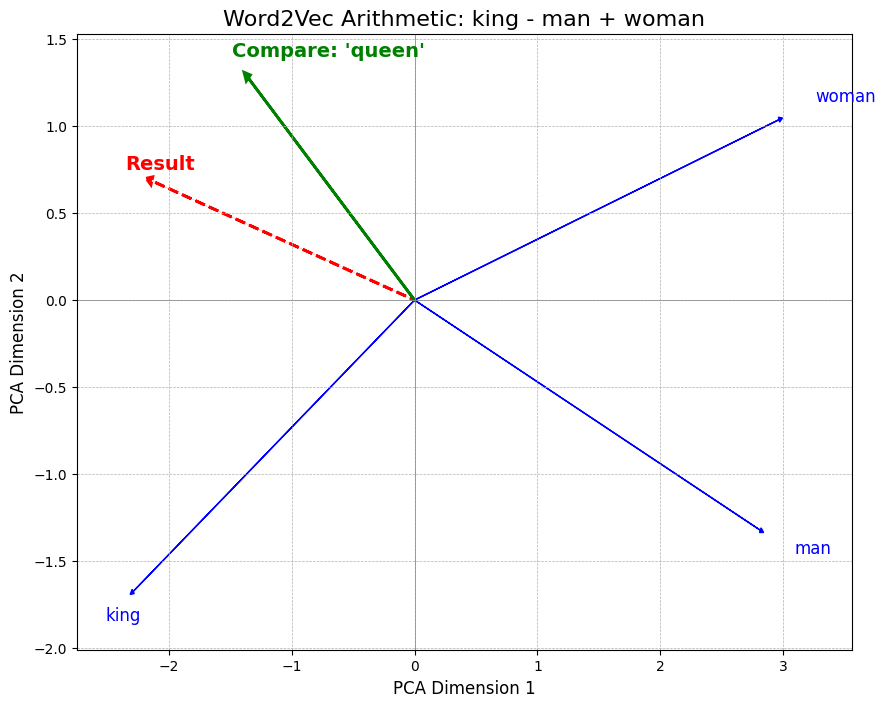

Expression: king - man + woman
Comparison Word: queen

2D Vector Positions:
  king: [-2.2905, -1.6760]
  man: [2.8143, -1.3237]
  woman: [2.9669, 1.0377]
  Result: [-2.1380, 0.6854]
  queen: [-1.3526, 1.2767]

Cosine Similarity: 0.8610


In [16]:
# edit area: input the expression and comparison you like-----------
expression = "king - man + woman"
comparison_word = "queen"
# -----------edit area end------------------------------------------

results = get_vector_results(expression, comparison_word)

print("Expression:", results["expression"])
print("Comparison Word:", results["comparison_word"])
print("\n2D Vector Positions:")
for word, coords in results["vector_positions"].items():
    print(f"  {word}: [{coords[0]:.4f}, {coords[1]:.4f}]")
print(f"\nCosine Similarity: {results['similarity']:.4f}")